In [ ]:
!pip install tensorflow

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
# mengimpor librarieS yang diperlukan
import numpy as np  # Library untuk operasi array dan komputasi numerik
import matplotlib.pyplot as plt  # Library untuk visualisasi data
import pandas as pd  # Library untuk manipulasi data
from sklearn.preprocessing import MinMaxScaler  # Class untuk normalisasi data
from keras.models import Sequential  # Class untuk membuat model neural network berurutan
from keras.layers import Dense, GRU, Dropout  # Layer GRU, Dropout, dan Dense untuk neural network
from keras.regularizers import l2  # Regularizer untuk L2 regularization (untuk mengurangi overfitting)
from keras.callbacks import EarlyStopping  # Callback untuk menghentikan training lebih awal jika model tidak membaik
from keras.optimizers import Adam  # Optimizer Adam untuk memperbarui bobot neural network
from sklearn.model_selection import train_test_split  # Fungsi untuk membagi dataset menjadi training dan testing
from sklearn.model_selection import train_test_split  # Mengimpor fungsi train_test_split dari library scikit-learn
from sklearn.metrics import mean_absolute_percentage_error  # Metrik untuk menghitung Mean Absolute Percentage Error (MAPE)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RNN, GRU
!pip install scikeras
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
df = pd.read_csv('nonmigasfix.csv')

In [ ]:
df.head()

,Bulan,Nilai
0,2012-01,1333329961
1,2012-02,1441687265
2,2012-03,1494575134
3,2012-04,1568526364
4,2012-05,1651995290


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Bulan   140 non-null    object
 1   Nilai   140 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.3+ KB


In [ ]:
df.isnull().sum()

,0
Bulan,0
Nilai,0


In [ ]:
df2 = df.copy()
# Mengganti nilai 0 dengan NaN
df2['Nilai'] = df2['Nilai'].replace(0, np.nan)

# Mengisi nilai yang hilang dengan interpolasi
df2['Nilai'] = df2['Nilai'].interpolate()

# Menampilkan DataFrame setelah interpolasi
print(df2)

       Bulan       Nilai
0    2012-01  1333329961
1    2012-02  1441687265
2    2012-03  1494575134
3    2012-04  1568526364
4    2012-05  1651995290
..       ...         ...
135  2023-04  1257703850
136  2023-05  1867427098
137  2023-06  1606918201
138  2023-07  1463548879
139  2023-08  1523190931

[140 rows x 2 columns]


In [ ]:
df2.isnull().sum()

,0
Bulan,0
Nilai,0


In [ ]:
print(df2.dtypes)

Bulan    object
Nilai     int64
dtype: object


In [ ]:
# merubah tipe data object to datetime
df2['Bulan'] = pd.to_datetime(df2['Bulan'], errors='coerce')

# melihat tipe data dataframe
print(df2.dtypes)

Bulan    datetime64[ns]
Nilai             int64
dtype: object


In [ ]:
df2.shape

(140, 2)

In [ ]:
df2.describe()

,Bulan,Nilai
count,140,1.400000e+02
mean,2017-10-16 02:03:25.714285824,1.234866e+09
min,2012-01-01 00:00:00,5.572650e+08
25%,2014-11-23 12:00:00,9.733115e+08
50%,2017-10-16 12:00:00,1.247749e+09
75%,2020-09-08 12:00:00,1.495513e+09
max,2023-08-01 00:00:00,2.055873e+09
std,NaN,3.330215e+08


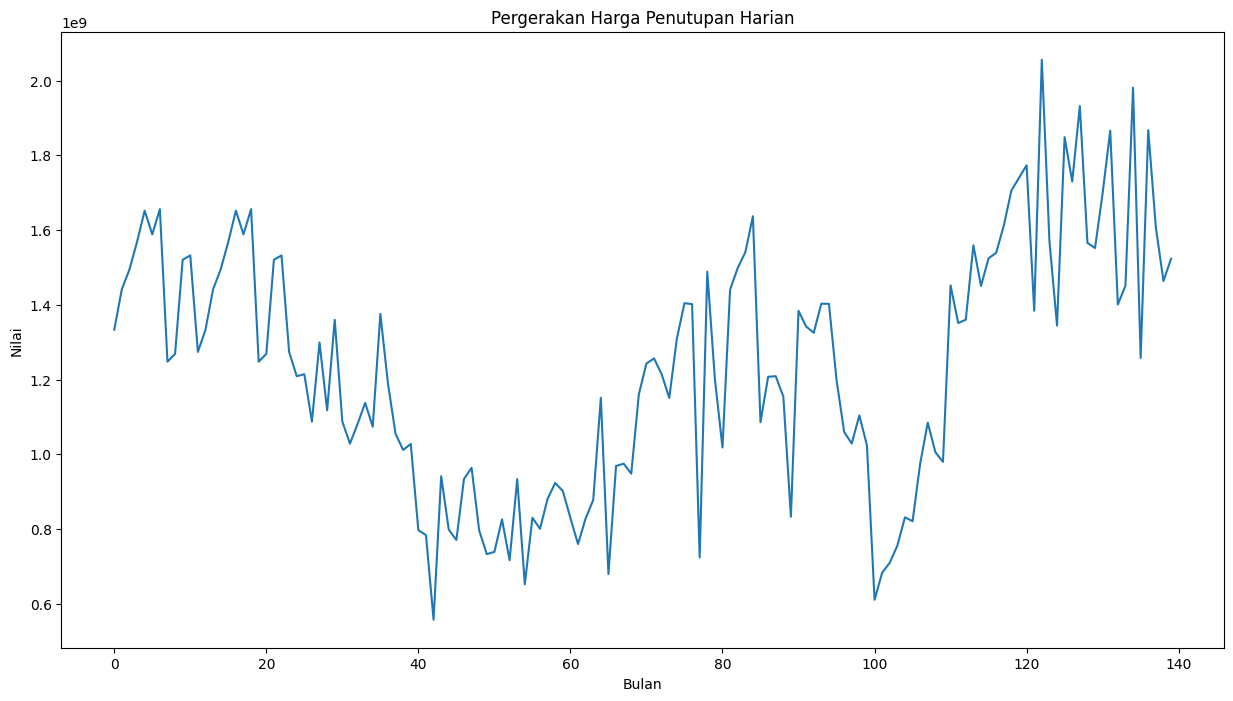

In [ ]:
# Visualisasi data harian
plt.figure(figsize=(15, 8))
plt.plot(df2.index, df2['Nilai'])
plt.title('Pergerakan Harga Penutupan Harian')
plt.xlabel('Bulan')
plt.ylabel('Nilai')
plt.show()

In [ ]:
# split data
train_size = int(len(df2) * 0.8) # Menentukan banyaknya data train yaitu sebesar 70% data
train = df2[:train_size]
test =df2[train_size:].reset_index(drop=True)

scaler = StandardScaler()
scaler.fit(train[['Nilai']])

train['scaled'] = scaler.transform(train[['Nilai']])
test['scaled'] = scaler.transform(test[['Nilai']])

<ipython-input-14-8cb0424f21e3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['scaled'] = scaler.transform(train[['Nilai']])


In [ ]:
train

,Bulan,Nilai,scaled
0,2012-01-01,1333329961,0.684668
1,2012-02-01,1441687265,1.065533
2,2012-03-01,1494575134,1.251429
3,2012-04-01,1568526364,1.511361
4,2012-05-01,1651995290,1.804747
...,...,...,...
107,2020-12-01,1084655340,-0.189401
108,2021-01-01,1005621915,-0.467196
109,2021-02-01,979677408,-0.558388
110,2021-03-01,1451992603,1.101756


In [ ]:
def sliding_window(data, window_size):
    sub_seq, next_values = [], []
    for i in range(len(data)-window_size):
        sub_seq.append(data[i:i+window_size])
        next_values.append(data[i+window_size])
    X = np.stack(sub_seq)
    y = np.array(next_values)
    return X,y

window_size = 6

X_train, y_train = sliding_window(train[['scaled']].values, window_size)
X_test, y_test = sliding_window(test[['scaled']].values, window_size)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(106, 6, 1) (106, 1)
(22, 6, 1) (22, 1)


In [ ]:
'''# Early Stopping
es = EarlyStopping(monitor='val_loss', mode="min", patience=10, verbose=1) #DIMODEL TAMBAHIN: callbacks=[es],'''

# Modify create_model to accept parameters as arguments
def create_model(GRU_unit=50, dropout=0.2):
    model = Sequential()
    # Tambahkan layer GRU pertama dengan return_sequences=True untuk menyambung ke layer GRU berikutnya
    model.add(GRU(units=GRU_unit, return_sequences=True, input_shape=(window_size, 1)))
    model.add(Dropout(dropout))
    # Layer GRU kedua tanpa return_sequences
    model.add(GRU(units=GRU_unit))
    model.add(Dropout(dropout))
    # Layer Dense untuk output
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model

# Wrap the model with KerasRegressor
model = KerasRegressor(model=create_model, epochs=100, validation_split=(X_test, y_test), batch_size=2, verbose=1)

# Define the grid search parameters to exactly match create_model argument names
param_grid = {
    'model__GRU_unit': [50],
    'model__dropout': [0.2]
}


In [ ]:
# Perform GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
grid_result = grid.fit(X_train, y_train, validation_data=(X_test, y_test))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - loss: 1.0039 - mae: 0.8353 - val_loss: 2.8973 - val_mae: 1.5227
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.6622 - mae: 0.6687 - val_loss: 1.7519 - val_mae: 1.1067
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5536 - mae: 0.6128 - val_loss: 1.0360 - val_mae: 0.8299
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4128 - mae: 0.5372 - val_loss: 0.7373 - val_mae: 0.7239
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4658 - mae: 0.5747 - val_loss: 0.6894 - val_mae: 0.7198
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4430 - mae: 0.5425 - val_loss: 0.7078 - val_mae: 0.7249
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5089 - mae: 0.5936 - val_loss: 0.7885 - val_mae: 0.7376
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4716 - mae: 0.5763 - val_loss: 0.8877 - val_mae: 0.7632
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4531 - mae:

In [ ]:
# Hasil grid search
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

Best: -0.4144055369249876 using {'model__GRU_unit': 50, 'model__dropout': 0.2}


In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Mengambil model terbaik
best_model = grid_result.best_estimator_.model

Best: -0.414406 using {'model__GRU_unit': 50, 'model__dropout': 0.2}
-0.414406 (0.869893) with: {'model__GRU_unit': 50, 'model__dropout': 0.2}


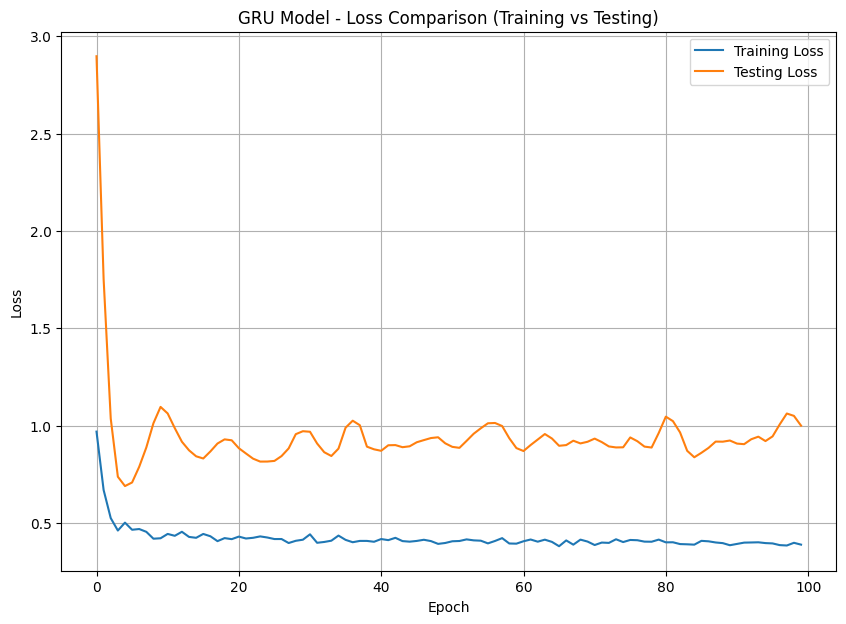

In [ ]:
best_model = grid_result.best_estimator_.model
history = grid_result.best_estimator_.history_
# grafik loss function MSE

# Plotting the MSE loss
plt.figure(figsize=(10, 7))  # Menentukan ukuran figure
plt.plot(history['loss'], label='Training Loss')  # Plot training loss
plt.plot(history['val_loss'], label='Testing Loss')  # Plot testing loss (menggunakan val_loss)
plt.xlabel('Epoch')  # Label sumbu x
plt.ylabel('Loss')  # Label sumbu y
plt.title('GRU Model - Loss Comparison (Training vs Testing)')  # Judul grafik
plt.legend()  # Menambahkan legenda
plt.grid(True)  # Menambahkan grid untuk tampilan yang lebih jelas
plt.show()  # Menampilkan grafik


In [ ]:
# ipython-input-29-c3bf5f26219a
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import GRU, Dropout, Dense
from scikeras.wrappers import KerasRegressor  # Import KerasRegressor from scikeras
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
# Early Stopping
es = EarlyStopping(monitor='val_loss', mode="min", patience=10, verbose=1)

# Modify create_model to accept parameters as arguments
def create_model(GRU_unit=50, dropout=0.2):
    model = Sequential()
    # Tambahkan layer GRU pertama dengan return_sequences=True untuk menyambung ke layer GRU berikutnya
    model.add(GRU(units=GRU_unit, return_sequences=True, input_shape=(window_size, 1)))
    model.add(Dropout(dropout))
    # Layer GRU kedua tanpa return_sequences
    model.add(GRU(units=GRU_unit))
    model.add(Dropout(dropout))
    # Layer Dense untuk output
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model

# Wrap the model with KerasRegressor
model = KerasRegressor(model=create_model, epochs=100, batch_size=32, verbose=1)

# Define the grid search parameters to exactly match create_model argument names
param_grid = {
    'model__GRU_unit': [30, 50],  # Menambahkan lebih dari satu parameter untuk variasi
    'model__dropout': [0.2, 0.3]
}

# Perform GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

# Fit the model
grid_result = grid.fit(X_train, y_train, validation_data=(X_test, y_test))

# Hasil grid search
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

# Summarize all results
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
results = []

for mean, stdev, param in zip(means, stds, params):
    results.append(f"Mean Score: {mean:.4f}, Std: {stdev:.4f}, Params: {param}")
    print(f"Mean Score: {mean:.4f}, Std: {stdev:.4f}, Params: {param}")

# Menyimpan semua hasil untuk dilihat lebih lanjut
with open("grid_search_results.txt", "w") as file:
    file.writelines("\n".join(results))

# Mengambil model terbaik
best_model = grid_result.best_estimator_.model

# Plotting the loss history
history = grid_result.best_estimator_.model.history.history

plt.figure(figsize=(10, 7))  # Menentukan ukuran figure
plt.plot(history['loss'], label='Training Loss')  # Plot training loss
plt.plot(history['val_loss'], label='Validation Loss')  # Plot validation loss
plt.xlabel('Epoch')  # Label sumbu x
plt.ylabel('Loss')  # Label sumbu y
plt.title('Best GRU Model - Loss Comparison (Training vs Validation)')  # Judul grafik
plt.legend()  # Menambahkan legenda
plt.grid(True)  # Menambahkan grid untuk tampilan yang lebih jelas
plt.show()  # Menampilkan grafik


ValueError: 
All the 12 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/data_adapter_utils.py", line 114, in check_data_cardinality
    raise ValueError(msg)
ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 22
'y' sizes: 28



In [ ]:
# ... (previous code) ...

# Perform GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

# Adjust y_train to match the number of samples in X_train
y_train_adjusted = y_train[:X_train.shape[0]]  # Select the first 'num_samples' elements of y_train

# Fit the model using the adjusted y_train
grid_result = grid.fit(X_train, y_train_adjusted, validation_data=(X_test, y_test))

# ... (rest of the code) ...

ValueError: 
All the 12 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/data_adapter_utils.py", line 114, in check_data_cardinality
    raise ValueError(msg)
ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 22
'y' sizes: 28



In [ ]:
!pip install scikeras # Install

In [ ]:
'''# Plotting the MSE loss
plt.plot(history['mae'], label='Training MAE')
plt.plot(history['val_mae'], label='Validation MAE')
plt.title('metric MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()
plt.show()'''

"# Plotting the MSE loss\nplt.plot(history['mae'], label='Training MAE')\nplt.plot(history['val_mae'], label='Validation MAE')\nplt.title('metric MAE')\nplt.ylabel('MAE')\nplt.xlabel('Epoch')\nplt.legend()\nplt.show()"

In [ ]:
# Access the best estimator found by GridSearchCV
best_model = grid_result.best_estimator_

# Perform predictions on the training and test data
predict_train = scaler.inverse_transform(best_model.predict(X_train).reshape(-1, 1))
true_train = scaler.inverse_transform(y_train)

predict_test = scaler.inverse_transform(best_model.predict(X_test).reshape(-1, 1))
true_test = scaler.inverse_transform(y_test)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


<ipython-input-24-6268b5b9f4a0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[:, 'predict'] = np.nan


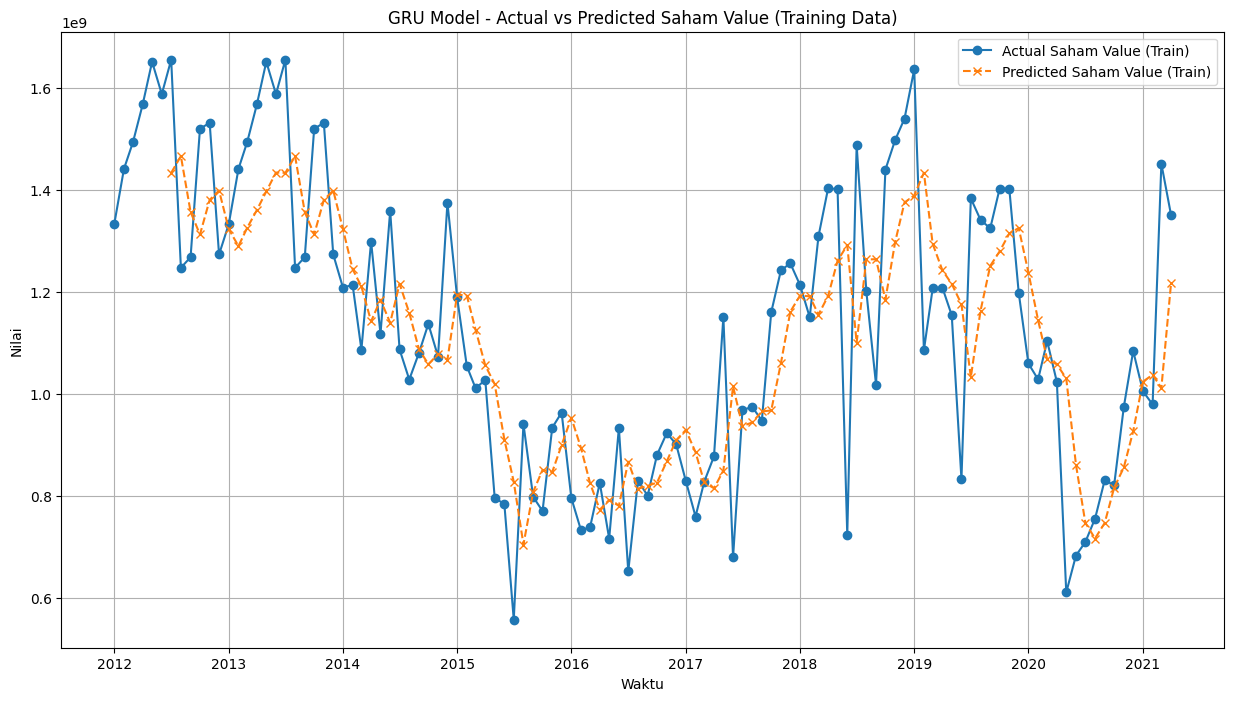

In [ ]:
'''train['predict'] = np.nan
train['predict'][-len(predict_train):] = predict_train[:,0]

plt.figure(figsize=(15,8))
sns.lineplot(data=train, x='Tanggal', y='Positif Harian', label = 'train')
sns.lineplot(data=train, x='Tanggal', y='predict', label = 'predict')'''

# Ensure 'predict' column is added with NaN values
train.loc[:, 'predict'] = np.nan

# Set the prediction values in the last rows
train.iloc[-len(predict_train):, train.columns.get_loc('predict')] = predict_train[:, 0]

# Plotting
plt.figure(figsize=(15, 8))

# Plot nilai aktual
plt.plot(train['Bulan'], train['Nilai'], label='Actual Saham Value (Train)', marker='o', linestyle='-')

# Plot nilai prediksi
plt.plot(train['Bulan'], train['predict'], label='Predicted Saham Value (Train)', marker='x', linestyle='--')

# Pengaturan tampilan plot
plt.title("GRU Model - Actual vs Predicted Saham Value (Training Data)")
plt.xlabel("Waktu")
plt.ylabel("Nilai")
plt.legend()
plt.grid(True)  # Tambahkan grid untuk kemudahan pembacaan
plt.show()


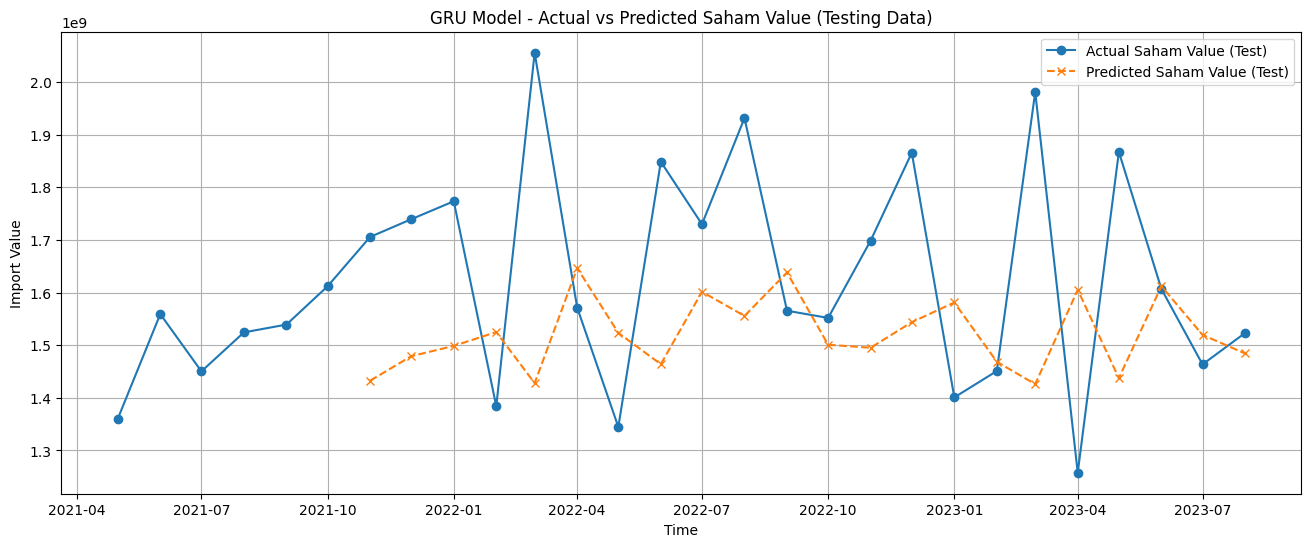

In [ ]:
# Ensure 'predict' column is added with NaN values for alignment
test['predict'] = np.nan
# Set prediction values in the last rows of the 'predict' column
test.iloc[-len(predict_test):, test.columns.get_loc('predict')] = predict_test[:, 0]

# Plotting the actual vs predicted values
plt.figure(figsize=(16, 6))  # Set figure size to match code 2
plt.plot(test['Bulan'], test['Nilai'], label='Actual Saham Value (Test)', marker='o', linestyle='-')  # Plot actual values with marker and linestyle
plt.plot(test['Bulan'], test['predict'], label='Predicted Saham Value (Test)', marker='x', linestyle='--')  # Plot predicted values with marker and linestyle
plt.title('GRU Model - Actual vs Predicted Saham Value (Testing Data)')  # Add title
plt.xlabel('Time')  # Label x-axis
plt.ylabel('Import Value')  # Label y-axis
plt.legend()  # Display legend
plt.grid(True)  # Add grid for clarity
plt.show()  # Show the plot


<ipython-input-26-768e022223e2>:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_future = pd.date_range(start=start_date, periods=n_future, freq='M')  # Frekuensi bulanan


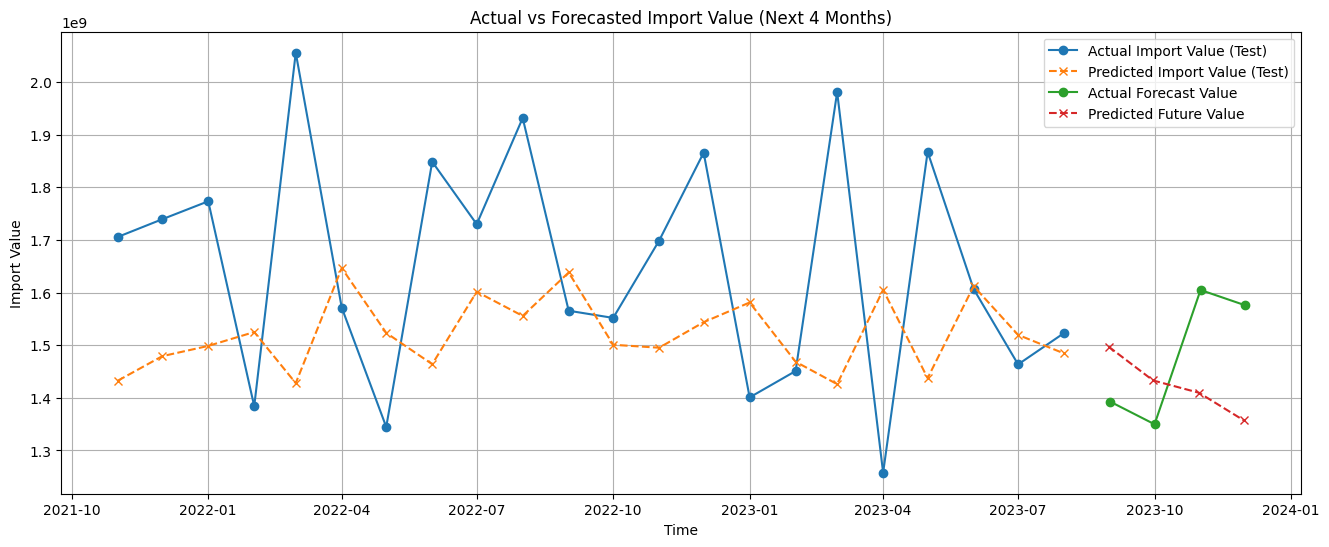

In [ ]:
# Transformasi data untuk input prediksi
y_test = scaler.transform(test[['Nilai']])

# Menentukan jumlah langkah prediksi ke depan dan memulai array prediksi
n_future = 4
future = []
X_new = y_test[-window_size:, 0].tolist()  # Menggunakan window terakhir dari data uji

# Melakukan prediksi untuk n_future langkah ke depan
for i in range(n_future):
    y_future = best_model.predict(np.array([X_new]).reshape(1, window_size, 1), verbose=0)
    future.append(y_future[0, 0])  # Simpan hasil prediksi
    X_new = X_new[1:]  # Geser window ke depan
    X_new.append(y_future[0, 0])  # Tambahkan prediksi baru ke window

# Mengembalikan hasil prediksi ke skala asli
future = scaler.inverse_transform(np.array(future).reshape(-1, 1))

# Membuat rentang tanggal untuk prediksi ke depan
start_date = pd.to_datetime(test['Bulan'].values[-1])  # Pastikan format waktu sesuai
date_future = pd.date_range(start=start_date, periods=n_future, freq='M')  # Frekuensi bulanan

# Pastikan data forecast_data memiliki format waktu yang benar
forecast_data = pd.read_csv('/content/forecast_data.csv')
forecast_data['Bulan'] = pd.to_datetime(forecast_data['Bulan'], errors='coerce')
forecast_data.set_index('Bulan', inplace=True)

# Plot data aktual dan prediksi
plt.figure(figsize=(16, 6))

# Plot 22 nilai aktual terakhir pada data test set
plt.plot(
    test['Bulan'].iloc[-22:],
    test['Nilai'].iloc[-22:],
    label='Actual Import Value (Test)',
    marker='o',
    linestyle='-'
)

# Plot prediksi model pada data test set
plt.plot(
    test['Bulan'].iloc[-22:],
    test['predict'].iloc[-22:],
    label='Predicted Import Value (Test)',
    marker='x',
    linestyle='--'
)

# Plot nilai aktual untuk data peramalan ke depan
plt.plot(
    forecast_data.index,
    forecast_data['Nilai'],
    label='Actual Forecast Value',
    marker='o',
    linestyle='-'
)

# Plot prediksi model untuk data peramalan ke depan
plt.plot(
    date_future,
    future,
    label='Predicted Future Value',
    marker='x',
    linestyle='--'
)

# Pengaturan judul, label, dan legenda
plt.title('Actual vs Forecasted Import Value (Next 4 Months)')
plt.xlabel('Time')
plt.ylabel('Import Value')
plt.legend()
plt.grid(True)
plt.show()
